In [1]:
%load_ext autoreload
% autoreload 2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='serif')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from geant_dataloader import rtnpy_load_data
from logistics import *
import random
import datetime
import os

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
print(torch.__version__)

0.4.0a0+200fb22


In [2]:
#currently only performs on 32 x 32 image size



torch.manual_seed(423312)
imageSize = 32
batchSize = 32
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
norm_scale = 'unif'
epoch=0 #will be updated during the run
num_epochs = 30
nc =1
ndf = 64
ngf = 64
nz = 6

In [3]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

('Random Seed: ', 25)
Using Cuda
cuda:1
('Using:', 'gpu', 0L)


In [36]:
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", num_events = 100, image_size = imageSize)
image_array1 = rtnpy_load_data("numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npz", image_size = imageSize)
image_array2 = rtnpy_load_data("numpy_data/geant4Data_30000Events_32ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)
image_array=np.concatenate((image_array1, image_array2),0)

np.savez_compressed("numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npz", array = image_array1)

In [5]:

print image_array.shape


(44992, 1, 32, 32)


In [6]:
#print norm_scale
normed_array, scale = normalize(image_array, norm_scale = norm_scale )

tensor_array_train = torch.stack([torch.Tensor(i) for i in normed_array[:30000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i) for i in normed_array[30000:]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=8)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 8)
print(train_loader)

In [12]:
def to_img(x, norm_scale = norm_scale, scale = scale):
    x = x.cpu().data.numpy()
    #x = 0.5 * (x + 1)
   # print x
   # x = np.clip(x, 0, 1)
    
    # this just drops the channel axis
    x = x.reshape([-1, 32, 32])

    x = unnormalize(x, scale = scale, norm_scale = norm_scale)
    #print x.max()
    
    return x

def plot_reconstructions(model, save_dir=None, epoch = epoch, n_events = num_epochs, latent_dim = nz, conv=True, simple=False, n=4, norm_scale = norm_scale, batchSize = batchSize, scale = scale):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data= next(iter(test_loader))
 
    if not conv:
        data = data.view([-1, 4096])

    true_imgs = data[0]
    encoded_imgs = model.encoder(data[0].to(device))
    if simple:
        encoded_imgs = F.relu(encoded_imgs)
  
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
    decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
    print(decoded_imgs.shape)
    
    rowsize = n * 2.5
    columnsize = 4
    fig, axn = plt.subplots(figsize=(rowsize, columnsize))
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        #print(true_imgs[i].max())
        if i == 0:
            im = plt.imshow(true_imgs[i], cmap=cmap)
        else: 
            plt.imshow(true_imgs[i], cmap=cmap)
        #if i == 0:
        #    ax.set_ylabel("Real")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        if i == 0:
            ax.set_ylabel("Real", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.25,0.5)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap=cmap)
        print(decoded_imgs[i].min(), decoded_imgs[i][0].max())
        if i == 0:
            ax.set_ylabel("Decoded", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.3,0.5)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    fig.subplots_adjust(wspace=-0.185, hspace=0.09)
    fig.suptitle(r"DCVAE Real and Decoded Samples of $e^{-}$ $E_{dep}$, "+ str(latent_dim) + " Latent Dim ", x=0.52, y = 1.02)
          
    if save_dir != None:
        #learning_rate = '%.0E' % Decimal(lr)
      
        filename = "DCVAE_EdepFor" + str(n_events) + "Events_" + str(latent_dim) +"latentDim_"+ str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    
    return

In [28]:

nz = 10
class  ConvolutionalAutoEncoder(nn.Module):
    def __init__(self,ngpu):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, 4,  2, 1),
            nn.MaxPool2d(3,stride=2),
            nn.ReLU(True),
            nn.Conv2d(ndf, nz, 4, 1 , 0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)

        )
        
#         nn.ConvTranspose2d(16, 16, 2, stride=3, padding=0),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 8, 2, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=0),
#             nn.Tanh(),
        self.decoder = nn.Sequential(
            
            # input is encoder final size ( height, width = 6 in this case), going into a convolution transpose
            nn.ConvTranspose2d( nz, ngf * 8, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            #nn.ReLU(True),
            # state size. (ngf*8) x 14 x 14
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 17 x 17
            nn.ConvTranspose2d(ngf * 4, ngf *2 , 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 33 x 33
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 2, bias=False),
            #nn.BatchNorm2d(nc),
            nn.Sigmoid(),
            # state size. (ngf) x x 32
            #nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            #nn.ReLU(inplace=True)
            #last_layer
    
        )
    def forward(self, x):
        #x = x.view(-1,1,64,64)
        if x.is_cuda and self.ngpu > 1:
            x = nn.parallel.data_parallel(self.encoder, x, range(self.ngpu))
            x = nn.parallel.data_parallel(self.decoder, x, range(self.ngpu))
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        return x
    

class  ConvolutionalAutoEncoder2(nn.Module):
    def __init__(self,ngpu):
        super(ConvolutionalAutoEncoder2, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
                #input 64 x 64
            nn.Conv2d(1, 32, 4, 2, 1), # 32 x 32
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 4, 2, 1),  # 16 x 16
            nn.BatchNorm2d(32),
            #nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1) , # 8 x 8
            nn.BatchNorm2d(64),
            #nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),  # 4 x 4
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 512, 4),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, nz, 1),
            # setup the non-linearity
            nn.ReLU(inplace=True)
        )
                
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(nz, 512, 1, 1, 0),  # 1 x 1
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 64, 4, 1, 0) , # 4 x 4
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 4, 2, 1),  # 8 x 8
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, 2, 1) , # 16 x 16
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),  # 32 x 32
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            # setup the non-linearity
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #x = x.view(-1,1,64,64)
        if x.is_cuda and self.ngpu > 1:
            x = nn.parallel.data_parallel(self.encoder, x, range(self.ngpu))
            x = nn.parallel.data_parallel(self.decoder, x, range(self.ngpu))
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        return x
    
    

class  ConvolutionalAutoEncoder32(nn.Module):
    def __init__(self,ngpu):
        super(ConvolutionalAutoEncoder32, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
                #input 64 x 64
            #nn.Conv2d(1, 32, 4, 2, 1), # 32 x 32
            #nn.BatchNorm2d(32),
            nn.Conv2d(1, 32, 5, 2, 1),  # 16 x 16
            nn.BatchNorm2d(32),
            #nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1) , # 8 x 8
            nn.BatchNorm2d(64),
            #nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1, 1),  # 4 x 4
            nn.BatchNorm2d(256),
            nn.Conv2d(256, nz, 3,1,1),
            #nn.BatchNorm2d(256),
           # nn.Conv2d(256, 10, 1),
            # setup the non-linearity
            nn.ReLU(inplace=True)
        )
                
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(nz, 256, 1, 1, 0),  # 1 x 1
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 64, 4, 2, 0) , # 4 x 4
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 5, 2, 1),  # 8 x 8
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 4, 1, 0) , # 16 x 16
            #nn.BatchNorm2d(32),
            #nn.ConvTranspose2d(32, 1, 1, 2, 1),  # 32 x 32
            #nn.BatchNorm2d(32),
            #nn.ConvTranspose2d(32, 1, 4, 2, 1),
            # setup the non-linearity
            nn.ReLU()
        )
        
    def forward(self, x):
        #x = x.view(-1,1,64,64)
        if x.is_cuda and self.ngpu > 1:
            x = nn.parallel.data_parallel(self.encoder, x, range(self.ngpu))
            x = nn.parallel.data_parallel(self.decoder, x, range(self.ngpu))
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        return x

In [29]:
model = ConvolutionalAutoEncoder32(ngpu).to(device)
optimizer = optim.Adam(model.parameters())

In [30]:
def train(epoch):
    for batch_idx, data in enumerate(train_loader,0):
        data = data[0].to(device)
        #print(data.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss -= F.binary_cross_entropy_with_logits(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/ConVAE/2018-05-29_18-43-52/
(32, 32, 32)
(43.89765, 47.04373)
(44.42235, 47.334393)
(41.546753, 48.674854)
(44.34427, 46.74891)
(42.734886, 47.126114)
(43.744576, 46.872475)


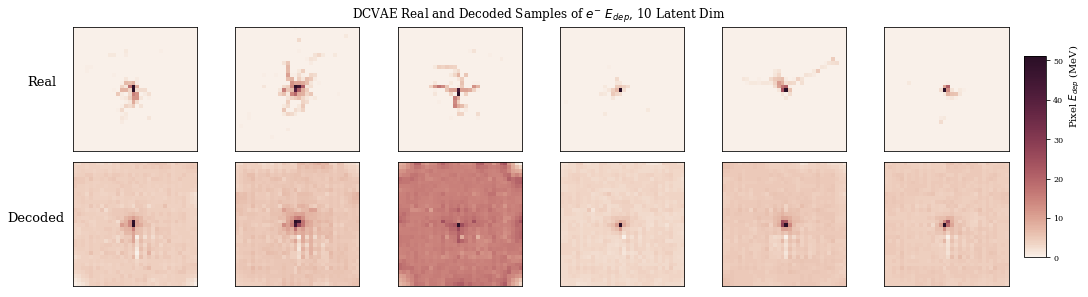

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


Train Epoch: 1 [0/30000 (0%)]	Loss: -0.764736
Train Epoch: 1 [1600/30000 (5%)]	Loss: -0.764730
Train Epoch: 1 [3200/30000 (11%)]	Loss: -0.764761
Train Epoch: 1 [4800/30000 (16%)]	Loss: -0.764766
Train Epoch: 1 [6400/30000 (21%)]	Loss: -0.764680
Train Epoch: 1 [8000/30000 (27%)]	Loss: -0.764710
Train Epoch: 1 [9600/30000 (32%)]	Loss: -0.764727
Train Epoch: 1 [11200/30000 (37%)]	Loss: -0.764728
Train Epoch: 1 [12800/30000 (43%)]	Loss: -0.764724
Train Epoch: 1 [14400/30000 (48%)]	Loss: -0.764716
Train Epoch: 1 [16000/30000 (53%)]	Loss: -0.764771
Train Epoch: 1 [17600/30000 (59%)]	Loss: -0.764737
Train Epoch: 1 [19200/30000 (64%)]	Loss: -0.764759
Train Epoch: 1 [20800/30000 (69%)]	Loss: -0.764723
Train Epoch: 1 [22400/30000 (75%)]	Loss: -0.764726
Train Epoch: 1 [24000/30000 (80%)]	Loss: -0.764769
Train Epoch: 1 [25600/30000 (85%)]	Loss: -0.764721
Train Epoch: 1 [27200/30000 (91%)]	Loss: -0.764741
Train Epoch: 1 [28800/30000 (96%)]	Loss: -0.764747
(32, 32, 32)
(44.165936, 46.780323)
(44.602

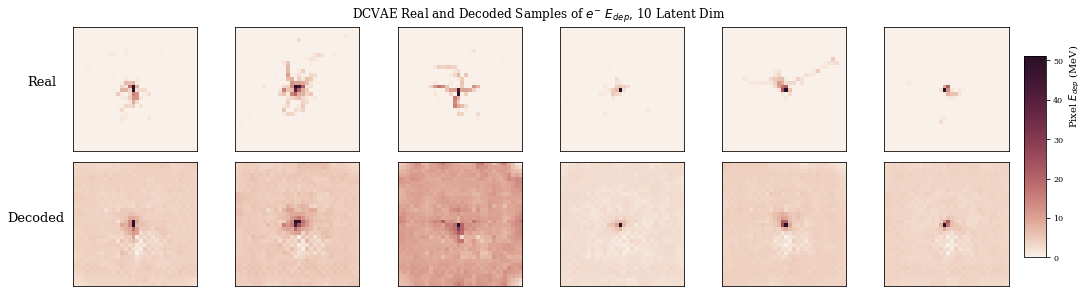

Train Epoch: 2 [0/30000 (0%)]	Loss: -0.764739
Train Epoch: 2 [1600/30000 (5%)]	Loss: -0.764740
Train Epoch: 2 [3200/30000 (11%)]	Loss: -0.764762
Train Epoch: 2 [4800/30000 (16%)]	Loss: -0.764774
Train Epoch: 2 [6400/30000 (21%)]	Loss: -0.764744
Train Epoch: 2 [8000/30000 (27%)]	Loss: -0.764709
Train Epoch: 2 [9600/30000 (32%)]	Loss: -0.764725
Train Epoch: 2 [11200/30000 (37%)]	Loss: -0.764726
Train Epoch: 2 [12800/30000 (43%)]	Loss: -0.764725
Train Epoch: 2 [14400/30000 (48%)]	Loss: -0.764714
Train Epoch: 2 [16000/30000 (53%)]	Loss: -0.764774
Train Epoch: 2 [17600/30000 (59%)]	Loss: -0.764736
Train Epoch: 2 [19200/30000 (64%)]	Loss: -0.764765
Train Epoch: 2 [20800/30000 (69%)]	Loss: -0.764737
Train Epoch: 2 [22400/30000 (75%)]	Loss: -0.764770
Train Epoch: 2 [24000/30000 (80%)]	Loss: -0.764760
Train Epoch: 2 [25600/30000 (85%)]	Loss: -0.764727
Train Epoch: 2 [27200/30000 (91%)]	Loss: -0.764741
Train Epoch: 2 [28800/30000 (96%)]	Loss: -0.764743
(32, 32, 32)
(44.099213, 46.616528)
(44.638

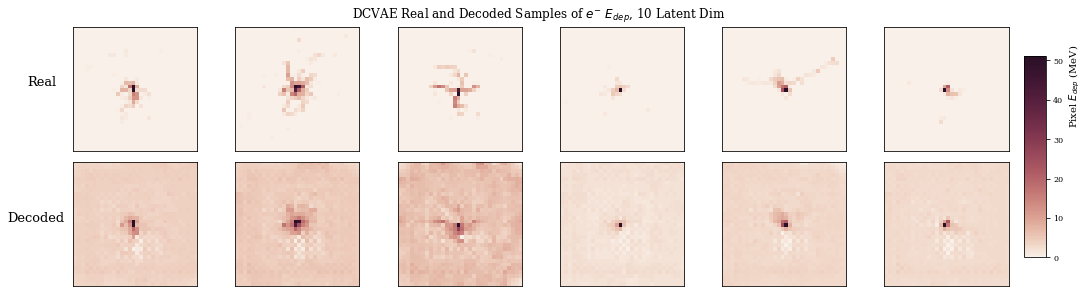

Train Epoch: 3 [0/30000 (0%)]	Loss: -0.764740
Train Epoch: 3 [1600/30000 (5%)]	Loss: -0.764741
Train Epoch: 3 [3200/30000 (11%)]	Loss: -0.764763
Train Epoch: 3 [4800/30000 (16%)]	Loss: -0.764778
Train Epoch: 3 [6400/30000 (21%)]	Loss: -0.764742
Train Epoch: 3 [8000/30000 (27%)]	Loss: -0.764704
Train Epoch: 3 [9600/30000 (32%)]	Loss: -0.764730
Train Epoch: 3 [11200/30000 (37%)]	Loss: -0.764733
Train Epoch: 3 [12800/30000 (43%)]	Loss: -0.764727
Train Epoch: 3 [14400/30000 (48%)]	Loss: -0.764719
Train Epoch: 3 [16000/30000 (53%)]	Loss: -0.764775
Train Epoch: 3 [17600/30000 (59%)]	Loss: -0.764741
Train Epoch: 3 [19200/30000 (64%)]	Loss: -0.764765
Train Epoch: 3 [20800/30000 (69%)]	Loss: -0.764734
Train Epoch: 3 [22400/30000 (75%)]	Loss: -0.764772
Train Epoch: 3 [24000/30000 (80%)]	Loss: -0.764753
Train Epoch: 3 [25600/30000 (85%)]	Loss: -0.764723
Train Epoch: 3 [27200/30000 (91%)]	Loss: -0.764743
Train Epoch: 3 [28800/30000 (96%)]	Loss: -0.764742
(32, 32, 32)
(41.811676, 46.49309)
(42.7096

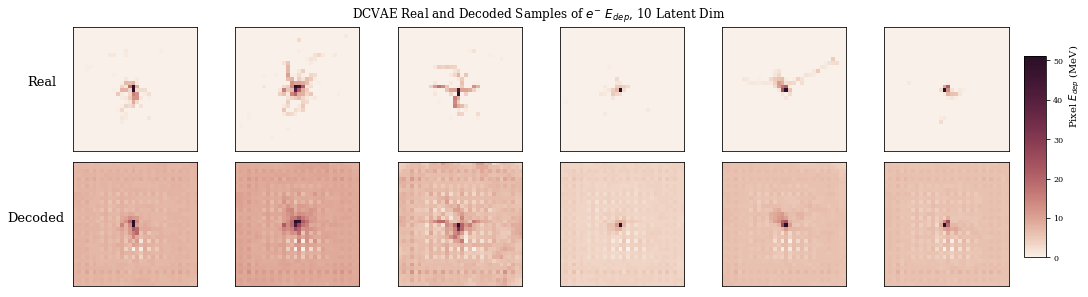

Train Epoch: 4 [0/30000 (0%)]	Loss: -0.764736
Train Epoch: 4 [1600/30000 (5%)]	Loss: -0.764742
Train Epoch: 4 [3200/30000 (11%)]	Loss: -0.764761
Train Epoch: 4 [4800/30000 (16%)]	Loss: -0.764778
Train Epoch: 4 [6400/30000 (21%)]	Loss: -0.764736
Train Epoch: 4 [8000/30000 (27%)]	Loss: -0.764716
Train Epoch: 4 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 4 [11200/30000 (37%)]	Loss: -0.764735
Train Epoch: 4 [12800/30000 (43%)]	Loss: -0.764727
Train Epoch: 4 [14400/30000 (48%)]	Loss: -0.764705
Train Epoch: 4 [16000/30000 (53%)]	Loss: -0.764774
Train Epoch: 4 [17600/30000 (59%)]	Loss: -0.764744
Train Epoch: 4 [19200/30000 (64%)]	Loss: -0.764765
Train Epoch: 4 [20800/30000 (69%)]	Loss: -0.764739
Train Epoch: 4 [22400/30000 (75%)]	Loss: -0.764772
Train Epoch: 4 [24000/30000 (80%)]	Loss: -0.764775
Train Epoch: 4 [25600/30000 (85%)]	Loss: -0.764725
Train Epoch: 4 [27200/30000 (91%)]	Loss: -0.764744
Train Epoch: 4 [28800/30000 (96%)]	Loss: -0.764748
(32, 32, 32)
(42.186054, 46.46973)
(43.1291

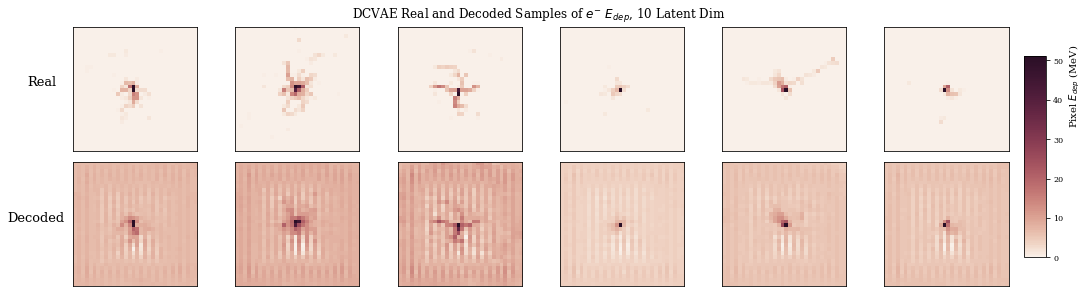

Train Epoch: 5 [0/30000 (0%)]	Loss: -0.764732
Train Epoch: 5 [1600/30000 (5%)]	Loss: -0.764742
Train Epoch: 5 [3200/30000 (11%)]	Loss: -0.764766
Train Epoch: 5 [4800/30000 (16%)]	Loss: -0.764776
Train Epoch: 5 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 5 [8000/30000 (27%)]	Loss: -0.764712
Train Epoch: 5 [9600/30000 (32%)]	Loss: -0.764732
Train Epoch: 5 [11200/30000 (37%)]	Loss: -0.764733
Train Epoch: 5 [12800/30000 (43%)]	Loss: -0.764724
Train Epoch: 5 [14400/30000 (48%)]	Loss: -0.764715
Train Epoch: 5 [16000/30000 (53%)]	Loss: -0.764774
Train Epoch: 5 [17600/30000 (59%)]	Loss: -0.764744
Train Epoch: 5 [19200/30000 (64%)]	Loss: -0.764764
Train Epoch: 5 [20800/30000 (69%)]	Loss: -0.764736
Train Epoch: 5 [22400/30000 (75%)]	Loss: -0.764773
Train Epoch: 5 [24000/30000 (80%)]	Loss: -0.764774
Train Epoch: 5 [25600/30000 (85%)]	Loss: -0.764725
Train Epoch: 5 [27200/30000 (91%)]	Loss: -0.764745
Train Epoch: 5 [28800/30000 (96%)]	Loss: -0.764749
(32, 32, 32)
(44.667477, 46.315525)
(44.654

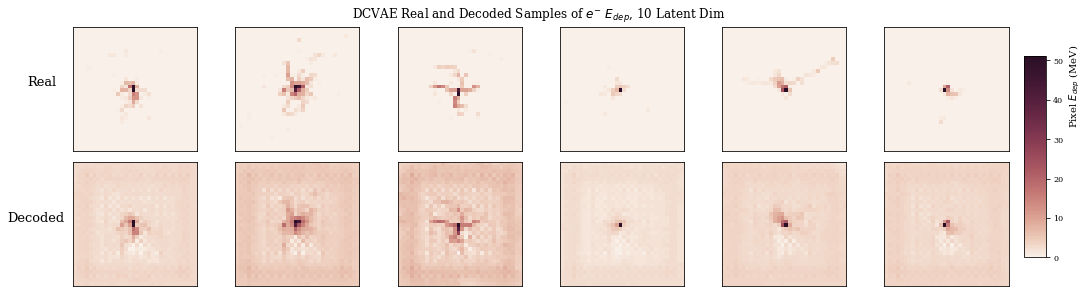

Train Epoch: 6 [0/30000 (0%)]	Loss: -0.764740
Train Epoch: 6 [1600/30000 (5%)]	Loss: -0.764743
Train Epoch: 6 [3200/30000 (11%)]	Loss: -0.764768
Train Epoch: 6 [4800/30000 (16%)]	Loss: -0.764775
Train Epoch: 6 [6400/30000 (21%)]	Loss: -0.764746
Train Epoch: 6 [8000/30000 (27%)]	Loss: -0.764715
Train Epoch: 6 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 6 [11200/30000 (37%)]	Loss: -0.764734
Train Epoch: 6 [12800/30000 (43%)]	Loss: -0.764725
Train Epoch: 6 [14400/30000 (48%)]	Loss: -0.764721
Train Epoch: 6 [16000/30000 (53%)]	Loss: -0.764775
Train Epoch: 6 [17600/30000 (59%)]	Loss: -0.764743
Train Epoch: 6 [19200/30000 (64%)]	Loss: -0.764765
Train Epoch: 6 [20800/30000 (69%)]	Loss: -0.764743
Train Epoch: 6 [22400/30000 (75%)]	Loss: -0.764768
Train Epoch: 6 [24000/30000 (80%)]	Loss: -0.764775
Train Epoch: 6 [25600/30000 (85%)]	Loss: -0.764727
Train Epoch: 6 [27200/30000 (91%)]	Loss: -0.764745
Train Epoch: 6 [28800/30000 (96%)]	Loss: -0.764751
(32, 32, 32)
(44.230835, 46.23667)
(44.2162

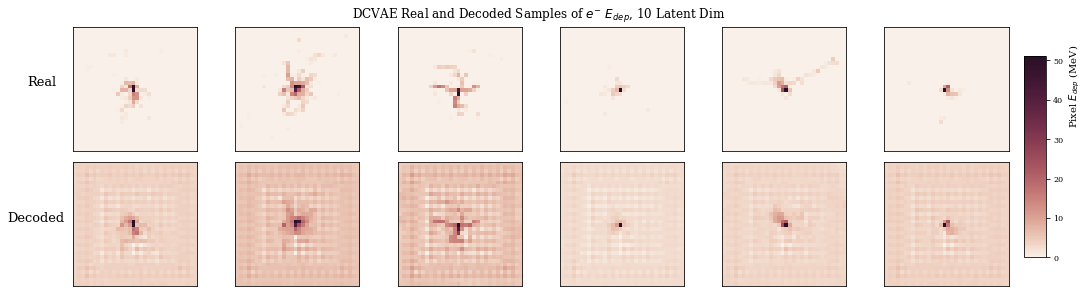

Train Epoch: 7 [0/30000 (0%)]	Loss: -0.764739
Train Epoch: 7 [1600/30000 (5%)]	Loss: -0.764744
Train Epoch: 7 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 7 [4800/30000 (16%)]	Loss: -0.764781
Train Epoch: 7 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 7 [8000/30000 (27%)]	Loss: -0.764715
Train Epoch: 7 [9600/30000 (32%)]	Loss: -0.764727
Train Epoch: 7 [11200/30000 (37%)]	Loss: -0.764727
Train Epoch: 7 [12800/30000 (43%)]	Loss: -0.764728
Train Epoch: 7 [14400/30000 (48%)]	Loss: -0.764720
Train Epoch: 7 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 7 [17600/30000 (59%)]	Loss: -0.764745
Train Epoch: 7 [19200/30000 (64%)]	Loss: -0.764767
Train Epoch: 7 [20800/30000 (69%)]	Loss: -0.764744
Train Epoch: 7 [22400/30000 (75%)]	Loss: -0.764775
Train Epoch: 7 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 7 [25600/30000 (85%)]	Loss: -0.764729
Train Epoch: 7 [27200/30000 (91%)]	Loss: -0.764744
Train Epoch: 7 [28800/30000 (96%)]	Loss: -0.764751
(32, 32, 32)
(44.46178, 46.24478)
(44.43850

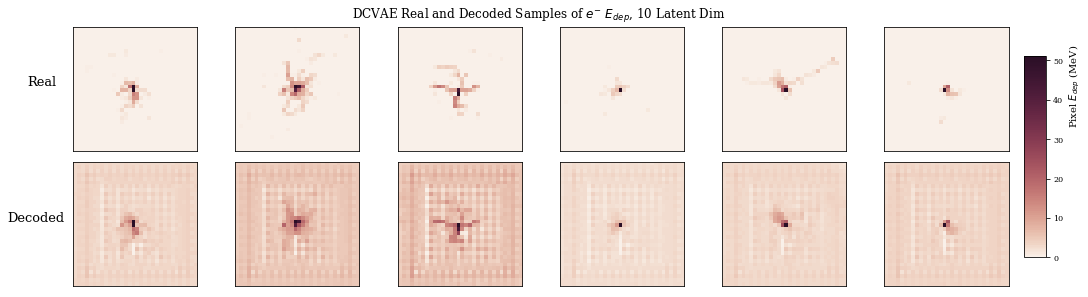

Train Epoch: 8 [0/30000 (0%)]	Loss: -0.764739
Train Epoch: 8 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 8 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 8 [4800/30000 (16%)]	Loss: -0.764780
Train Epoch: 8 [6400/30000 (21%)]	Loss: -0.764748
Train Epoch: 8 [8000/30000 (27%)]	Loss: -0.764718
Train Epoch: 8 [9600/30000 (32%)]	Loss: -0.764732
Train Epoch: 8 [11200/30000 (37%)]	Loss: -0.764736
Train Epoch: 8 [12800/30000 (43%)]	Loss: -0.764728
Train Epoch: 8 [14400/30000 (48%)]	Loss: -0.764721
Train Epoch: 8 [16000/30000 (53%)]	Loss: -0.764778
Train Epoch: 8 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 8 [19200/30000 (64%)]	Loss: -0.764767
Train Epoch: 8 [20800/30000 (69%)]	Loss: -0.764745
Train Epoch: 8 [22400/30000 (75%)]	Loss: -0.764770
Train Epoch: 8 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 8 [25600/30000 (85%)]	Loss: -0.764730
Train Epoch: 8 [27200/30000 (91%)]	Loss: -0.764745
Train Epoch: 8 [28800/30000 (96%)]	Loss: -0.764751
(32, 32, 32)
(45.162163, 46.189777)
(45.151

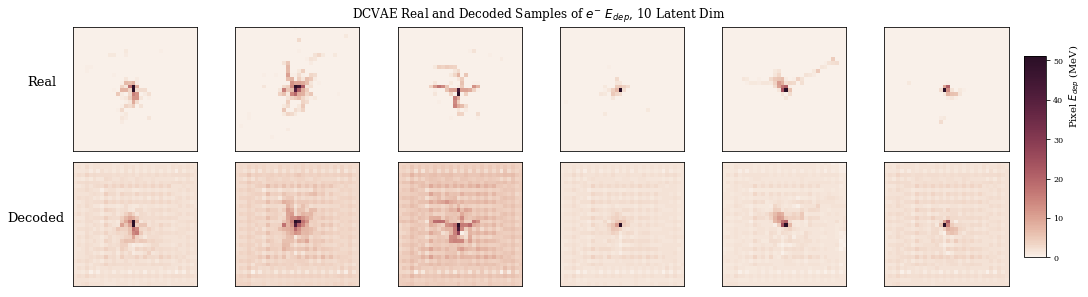

Train Epoch: 9 [0/30000 (0%)]	Loss: -0.764741
Train Epoch: 9 [1600/30000 (5%)]	Loss: -0.764744
Train Epoch: 9 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 9 [4800/30000 (16%)]	Loss: -0.764781
Train Epoch: 9 [6400/30000 (21%)]	Loss: -0.764745
Train Epoch: 9 [8000/30000 (27%)]	Loss: -0.764718
Train Epoch: 9 [9600/30000 (32%)]	Loss: -0.764730
Train Epoch: 9 [11200/30000 (37%)]	Loss: -0.764736
Train Epoch: 9 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 9 [14400/30000 (48%)]	Loss: -0.764719
Train Epoch: 9 [16000/30000 (53%)]	Loss: -0.764778
Train Epoch: 9 [17600/30000 (59%)]	Loss: -0.764745
Train Epoch: 9 [19200/30000 (64%)]	Loss: -0.764767
Train Epoch: 9 [20800/30000 (69%)]	Loss: -0.764745
Train Epoch: 9 [22400/30000 (75%)]	Loss: -0.764776
Train Epoch: 9 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 9 [25600/30000 (85%)]	Loss: -0.764731
Train Epoch: 9 [27200/30000 (91%)]	Loss: -0.764745
Train Epoch: 9 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.570183, 46.229397)
(45.534

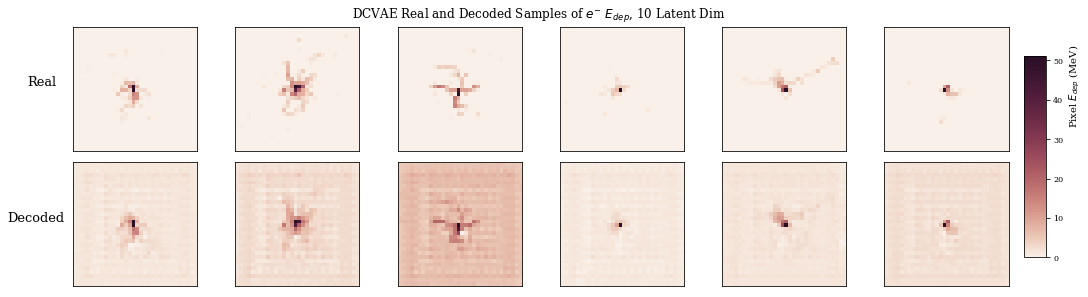

Train Epoch: 10 [0/30000 (0%)]	Loss: -0.764742
Train Epoch: 10 [1600/30000 (5%)]	Loss: -0.764743
Train Epoch: 10 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 10 [4800/30000 (16%)]	Loss: -0.764781
Train Epoch: 10 [6400/30000 (21%)]	Loss: -0.764746
Train Epoch: 10 [8000/30000 (27%)]	Loss: -0.764718
Train Epoch: 10 [9600/30000 (32%)]	Loss: -0.764732
Train Epoch: 10 [11200/30000 (37%)]	Loss: -0.764737
Train Epoch: 10 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 10 [14400/30000 (48%)]	Loss: -0.764719
Train Epoch: 10 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 10 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 10 [19200/30000 (64%)]	Loss: -0.764768
Train Epoch: 10 [20800/30000 (69%)]	Loss: -0.764745
Train Epoch: 10 [22400/30000 (75%)]	Loss: -0.764776
Train Epoch: 10 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 10 [25600/30000 (85%)]	Loss: -0.764729
Train Epoch: 10 [27200/30000 (91%)]	Loss: -0.764745
Train Epoch: 10 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.444004,

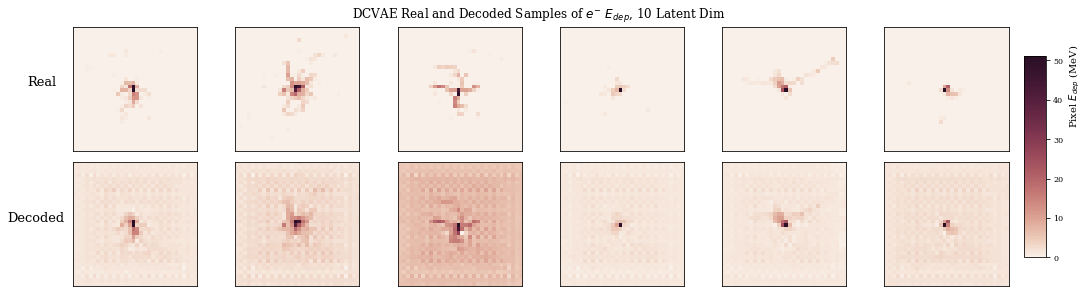

Train Epoch: 11 [0/30000 (0%)]	Loss: -0.764741
Train Epoch: 11 [1600/30000 (5%)]	Loss: -0.764743
Train Epoch: 11 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 11 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 11 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 11 [8000/30000 (27%)]	Loss: -0.764717
Train Epoch: 11 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 11 [11200/30000 (37%)]	Loss: -0.764736
Train Epoch: 11 [12800/30000 (43%)]	Loss: -0.764728
Train Epoch: 11 [14400/30000 (48%)]	Loss: -0.764721
Train Epoch: 11 [16000/30000 (53%)]	Loss: -0.764778
Train Epoch: 11 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 11 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 11 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 11 [22400/30000 (75%)]	Loss: -0.764777
Train Epoch: 11 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 11 [25600/30000 (85%)]	Loss: -0.764731
Train Epoch: 11 [27200/30000 (91%)]	Loss: -0.764745
Train Epoch: 11 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.76309, 

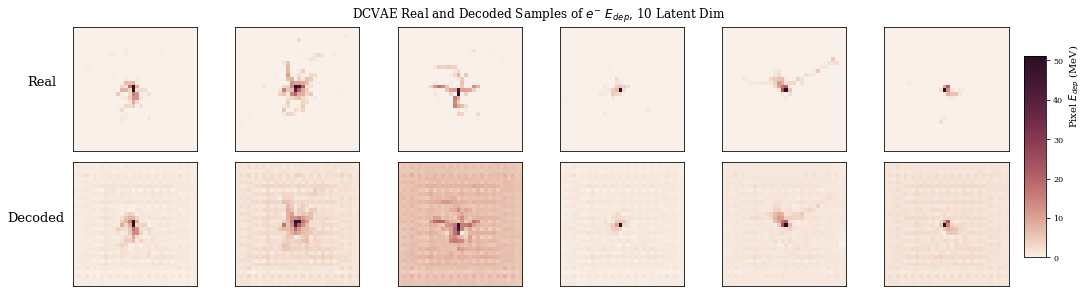

Train Epoch: 12 [0/30000 (0%)]	Loss: -0.764742
Train Epoch: 12 [1600/30000 (5%)]	Loss: -0.764743
Train Epoch: 12 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 12 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 12 [6400/30000 (21%)]	Loss: -0.764750
Train Epoch: 12 [8000/30000 (27%)]	Loss: -0.764718
Train Epoch: 12 [9600/30000 (32%)]	Loss: -0.764731
Train Epoch: 12 [11200/30000 (37%)]	Loss: -0.764737
Train Epoch: 12 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 12 [14400/30000 (48%)]	Loss: -0.764721
Train Epoch: 12 [16000/30000 (53%)]	Loss: -0.764778
Train Epoch: 12 [17600/30000 (59%)]	Loss: -0.764745
Train Epoch: 12 [19200/30000 (64%)]	Loss: -0.764768
Train Epoch: 12 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 12 [22400/30000 (75%)]	Loss: -0.764777
Train Epoch: 12 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 12 [25600/30000 (85%)]	Loss: -0.764731
Train Epoch: 12 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 12 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.787956,

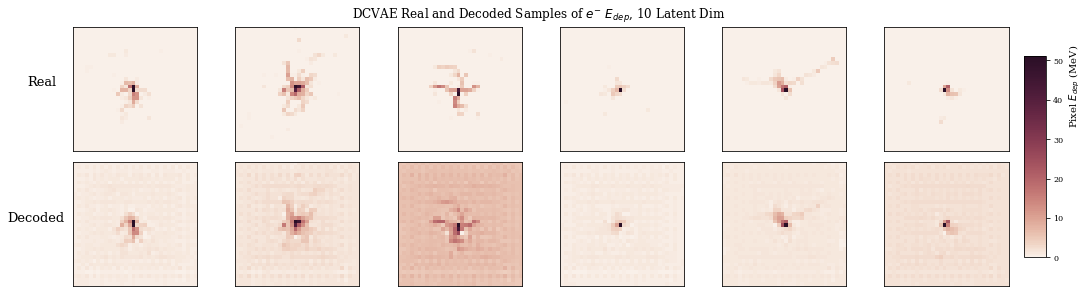

Train Epoch: 13 [0/30000 (0%)]	Loss: -0.764743
Train Epoch: 13 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 13 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 13 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 13 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 13 [8000/30000 (27%)]	Loss: -0.764718
Train Epoch: 13 [9600/30000 (32%)]	Loss: -0.764732
Train Epoch: 13 [11200/30000 (37%)]	Loss: -0.764737
Train Epoch: 13 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 13 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 13 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 13 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 13 [19200/30000 (64%)]	Loss: -0.764768
Train Epoch: 13 [20800/30000 (69%)]	Loss: -0.764745
Train Epoch: 13 [22400/30000 (75%)]	Loss: -0.764777
Train Epoch: 13 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 13 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 13 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 13 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.421333,

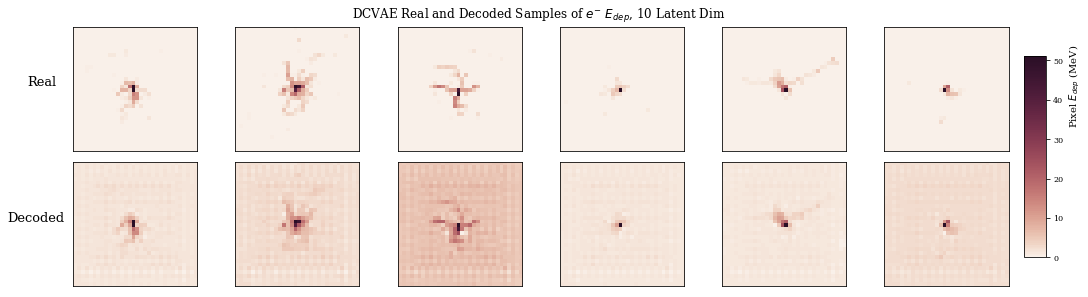

Train Epoch: 14 [0/30000 (0%)]	Loss: -0.764743
Train Epoch: 14 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 14 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 14 [4800/30000 (16%)]	Loss: -0.764781
Train Epoch: 14 [6400/30000 (21%)]	Loss: -0.764748
Train Epoch: 14 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 14 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 14 [11200/30000 (37%)]	Loss: -0.764737
Train Epoch: 14 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 14 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 14 [16000/30000 (53%)]	Loss: -0.764778
Train Epoch: 14 [17600/30000 (59%)]	Loss: -0.764745
Train Epoch: 14 [19200/30000 (64%)]	Loss: -0.764768
Train Epoch: 14 [20800/30000 (69%)]	Loss: -0.764745
Train Epoch: 14 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 14 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 14 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 14 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 14 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(44.7738, 4

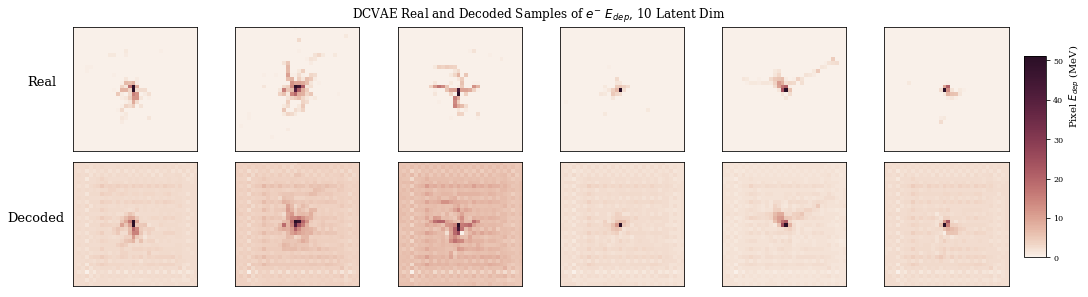

Train Epoch: 15 [0/30000 (0%)]	Loss: -0.764742
Train Epoch: 15 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 15 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 15 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 15 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 15 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 15 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 15 [11200/30000 (37%)]	Loss: -0.764737
Train Epoch: 15 [12800/30000 (43%)]	Loss: -0.764728
Train Epoch: 15 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 15 [16000/30000 (53%)]	Loss: -0.764778
Train Epoch: 15 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 15 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 15 [20800/30000 (69%)]	Loss: -0.764745
Train Epoch: 15 [22400/30000 (75%)]	Loss: -0.764777
Train Epoch: 15 [24000/30000 (80%)]	Loss: -0.764776
Train Epoch: 15 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 15 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 15 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.12688, 

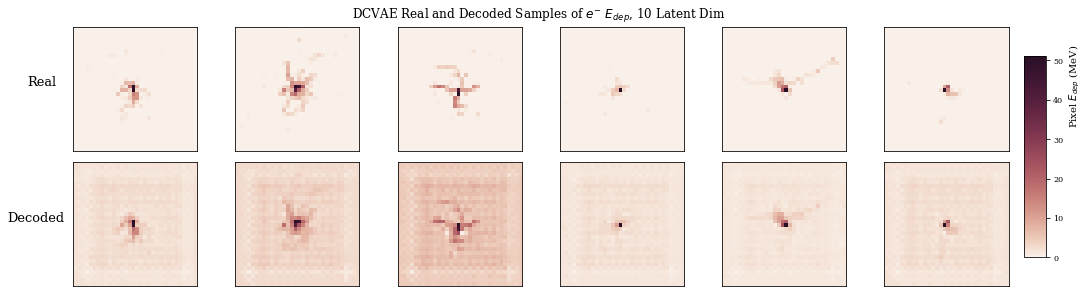

Train Epoch: 16 [0/30000 (0%)]	Loss: -0.764742
Train Epoch: 16 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 16 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 16 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 16 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 16 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 16 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 16 [11200/30000 (37%)]	Loss: -0.764737
Train Epoch: 16 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 16 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 16 [16000/30000 (53%)]	Loss: -0.764778
Train Epoch: 16 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 16 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 16 [20800/30000 (69%)]	Loss: -0.764745
Train Epoch: 16 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 16 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 16 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 16 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 16 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.36118, 

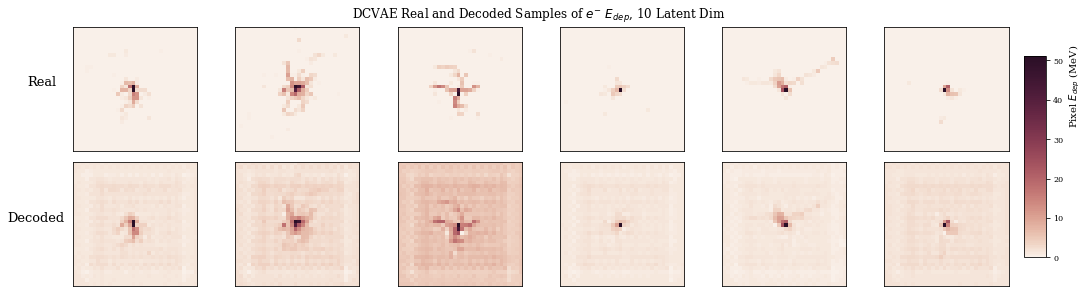

Train Epoch: 17 [0/30000 (0%)]	Loss: -0.764742
Train Epoch: 17 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 17 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 17 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 17 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 17 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 17 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 17 [11200/30000 (37%)]	Loss: -0.764737
Train Epoch: 17 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 17 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 17 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 17 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 17 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 17 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 17 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 17 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 17 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 17 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 17 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.463554,

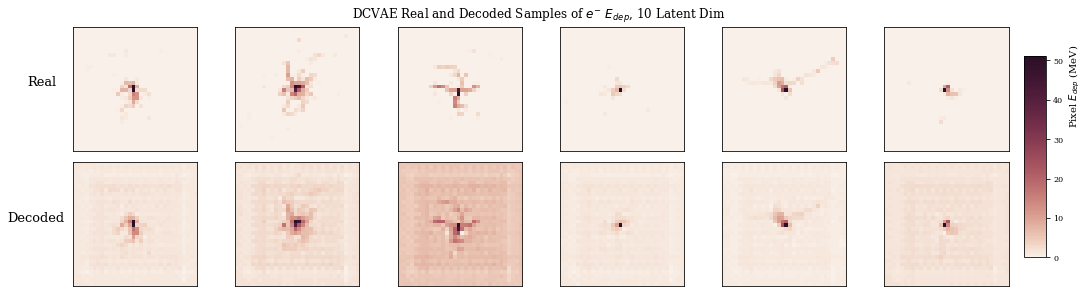

Train Epoch: 18 [0/30000 (0%)]	Loss: -0.764743
Train Epoch: 18 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 18 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 18 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 18 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 18 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 18 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 18 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 18 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 18 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 18 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 18 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 18 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 18 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 18 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 18 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 18 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 18 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 18 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.620842,

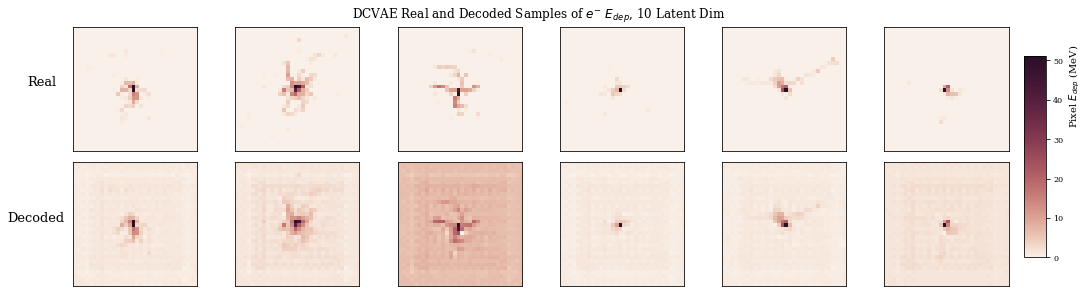

Train Epoch: 19 [0/30000 (0%)]	Loss: -0.764743
Train Epoch: 19 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 19 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 19 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 19 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 19 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 19 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 19 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 19 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 19 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 19 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 19 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 19 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 19 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 19 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 19 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 19 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 19 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 19 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.717373,

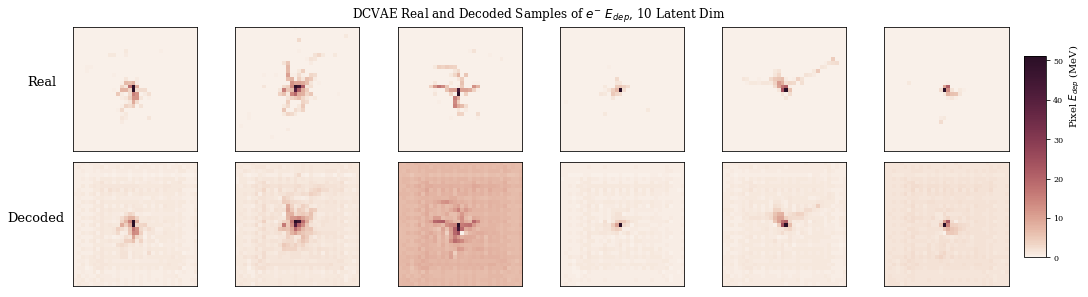

Train Epoch: 20 [0/30000 (0%)]	Loss: -0.764743
Train Epoch: 20 [1600/30000 (5%)]	Loss: -0.764746
Train Epoch: 20 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 20 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 20 [6400/30000 (21%)]	Loss: -0.764749
Train Epoch: 20 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 20 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 20 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 20 [12800/30000 (43%)]	Loss: -0.764729
Train Epoch: 20 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 20 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 20 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 20 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 20 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 20 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 20 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 20 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 20 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 20 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.740826,

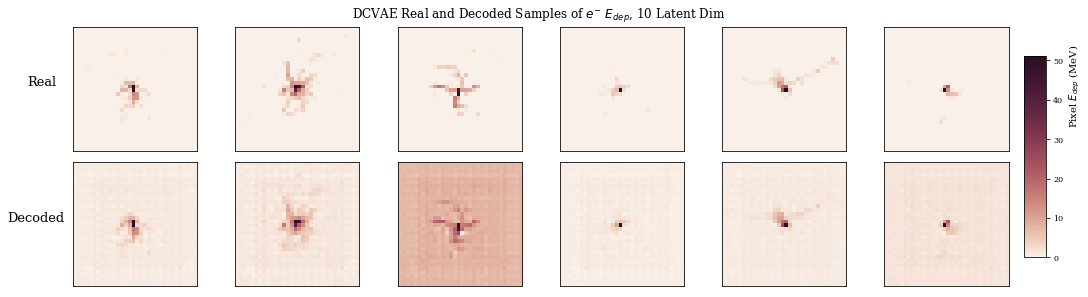

Train Epoch: 21 [0/30000 (0%)]	Loss: -0.764743
Train Epoch: 21 [1600/30000 (5%)]	Loss: -0.764746
Train Epoch: 21 [3200/30000 (11%)]	Loss: -0.764770
Train Epoch: 21 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 21 [6400/30000 (21%)]	Loss: -0.764750
Train Epoch: 21 [8000/30000 (27%)]	Loss: -0.764719
Train Epoch: 21 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 21 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 21 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 21 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 21 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 21 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 21 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 21 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 21 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 21 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 21 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 21 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 21 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.70638, 

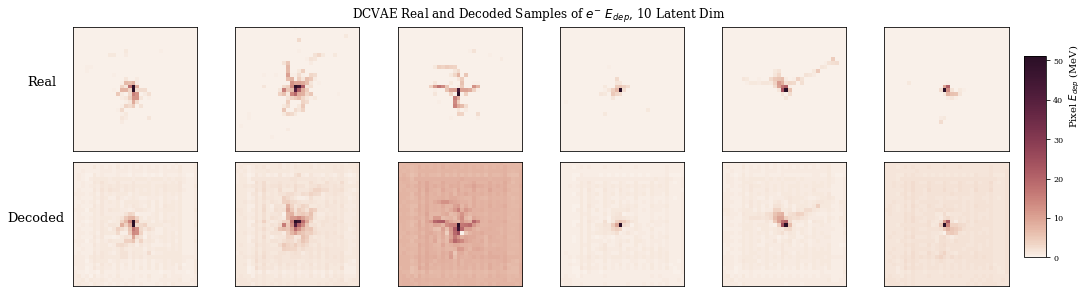

Train Epoch: 22 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 22 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 22 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 22 [4800/30000 (16%)]	Loss: -0.764782
Train Epoch: 22 [6400/30000 (21%)]	Loss: -0.764750
Train Epoch: 22 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 22 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 22 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 22 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 22 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 22 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 22 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 22 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 22 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 22 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 22 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 22 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 22 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 22 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.55551, 

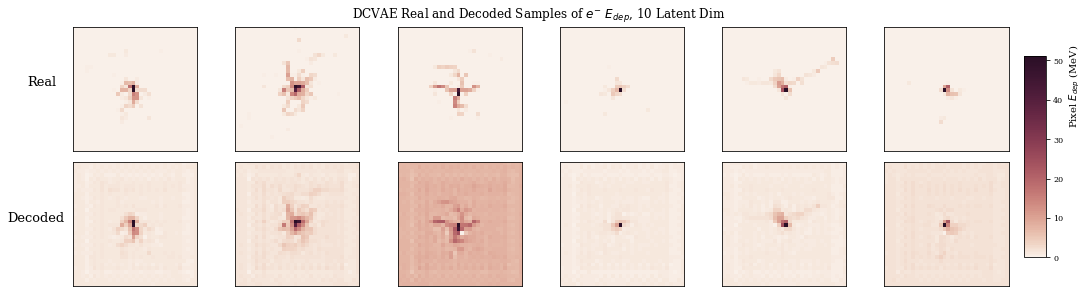

Train Epoch: 23 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 23 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 23 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 23 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 23 [6400/30000 (21%)]	Loss: -0.764750
Train Epoch: 23 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 23 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 23 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 23 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 23 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 23 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 23 [17600/30000 (59%)]	Loss: -0.764746
Train Epoch: 23 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 23 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 23 [22400/30000 (75%)]	Loss: -0.764778
Train Epoch: 23 [24000/30000 (80%)]	Loss: -0.764777
Train Epoch: 23 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 23 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 23 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.688435,

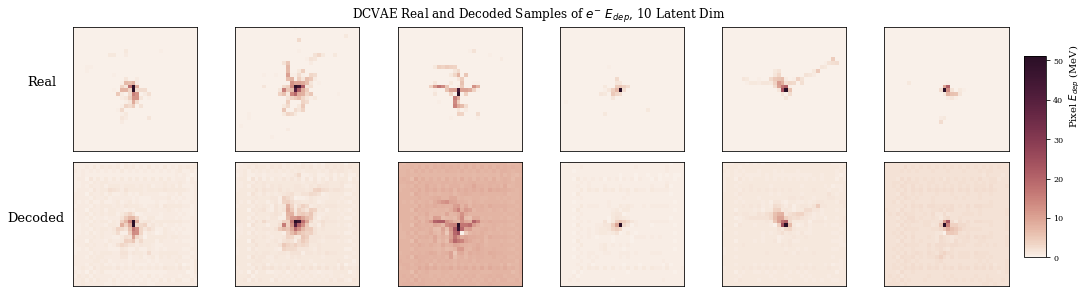

Train Epoch: 24 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 24 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 24 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 24 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 24 [6400/30000 (21%)]	Loss: -0.764750
Train Epoch: 24 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 24 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 24 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 24 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 24 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 24 [16000/30000 (53%)]	Loss: -0.764779
Train Epoch: 24 [17600/30000 (59%)]	Loss: -0.764747
Train Epoch: 24 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 24 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 24 [22400/30000 (75%)]	Loss: -0.764779
Train Epoch: 24 [24000/30000 (80%)]	Loss: -0.764778
Train Epoch: 24 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 24 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 24 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.698376,

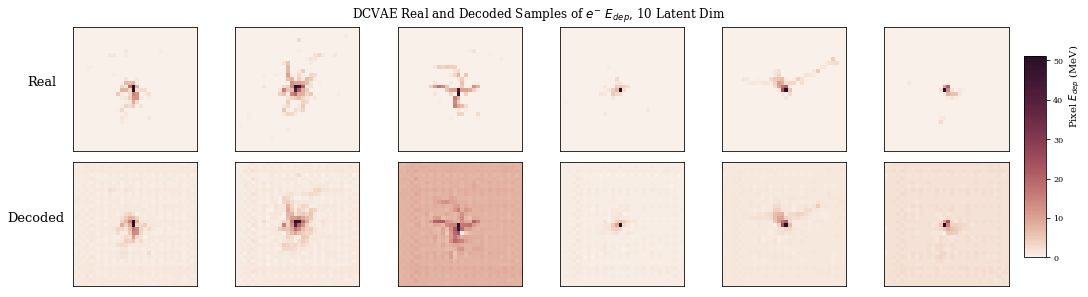

Train Epoch: 25 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 25 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 25 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 25 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 25 [6400/30000 (21%)]	Loss: -0.764750
Train Epoch: 25 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 25 [9600/30000 (32%)]	Loss: -0.764733
Train Epoch: 25 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 25 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 25 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 25 [16000/30000 (53%)]	Loss: -0.764780
Train Epoch: 25 [17600/30000 (59%)]	Loss: -0.764747
Train Epoch: 25 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 25 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 25 [22400/30000 (75%)]	Loss: -0.764779
Train Epoch: 25 [24000/30000 (80%)]	Loss: -0.764778
Train Epoch: 25 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 25 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 25 [28800/30000 (96%)]	Loss: -0.764752
(32, 32, 32)
(45.734455,

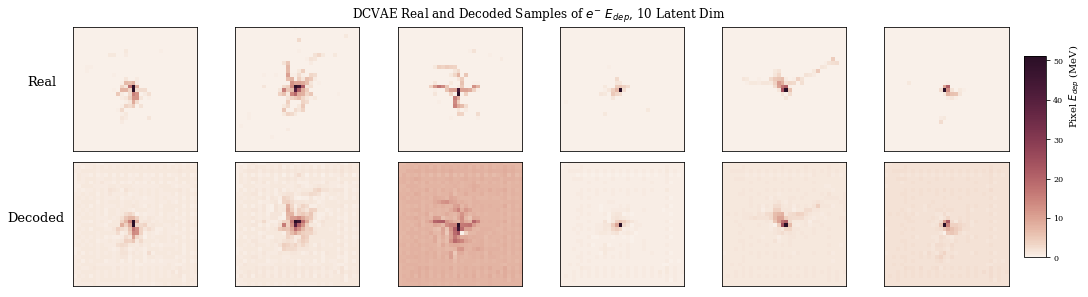

Train Epoch: 26 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 26 [1600/30000 (5%)]	Loss: -0.764746
Train Epoch: 26 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 26 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 26 [6400/30000 (21%)]	Loss: -0.764751
Train Epoch: 26 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 26 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 26 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 26 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 26 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 26 [16000/30000 (53%)]	Loss: -0.764780
Train Epoch: 26 [17600/30000 (59%)]	Loss: -0.764747
Train Epoch: 26 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 26 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 26 [22400/30000 (75%)]	Loss: -0.764779
Train Epoch: 26 [24000/30000 (80%)]	Loss: -0.764778
Train Epoch: 26 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 26 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 26 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.74313, 

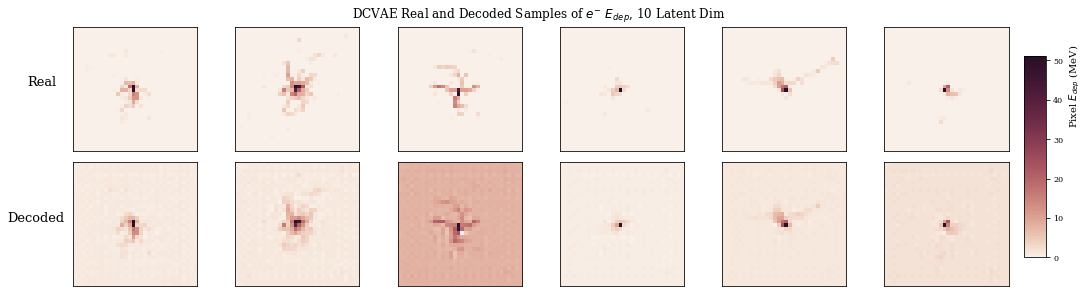

Train Epoch: 27 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 27 [1600/30000 (5%)]	Loss: -0.764746
Train Epoch: 27 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 27 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 27 [6400/30000 (21%)]	Loss: -0.764751
Train Epoch: 27 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 27 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 27 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 27 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 27 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 27 [16000/30000 (53%)]	Loss: -0.764780
Train Epoch: 27 [17600/30000 (59%)]	Loss: -0.764747
Train Epoch: 27 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 27 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 27 [22400/30000 (75%)]	Loss: -0.764779
Train Epoch: 27 [24000/30000 (80%)]	Loss: -0.764778
Train Epoch: 27 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 27 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 27 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.731068,

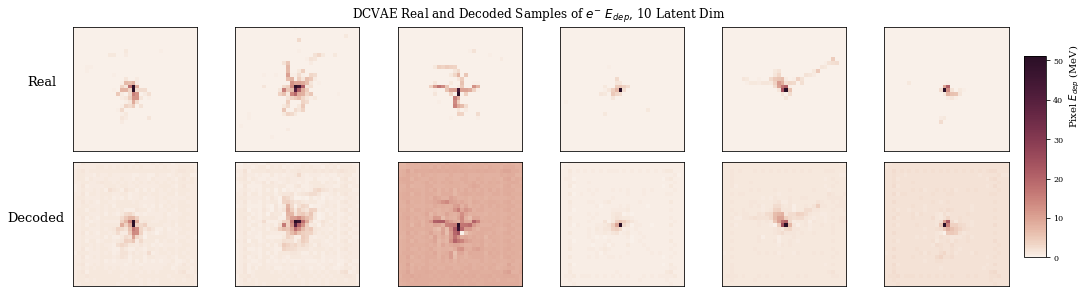

Train Epoch: 28 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 28 [1600/30000 (5%)]	Loss: -0.764745
Train Epoch: 28 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 28 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 28 [6400/30000 (21%)]	Loss: -0.764751
Train Epoch: 28 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 28 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 28 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 28 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 28 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 28 [16000/30000 (53%)]	Loss: -0.764780
Train Epoch: 28 [17600/30000 (59%)]	Loss: -0.764747
Train Epoch: 28 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 28 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 28 [22400/30000 (75%)]	Loss: -0.764779
Train Epoch: 28 [24000/30000 (80%)]	Loss: -0.764778
Train Epoch: 28 [25600/30000 (85%)]	Loss: -0.764732
Train Epoch: 28 [27200/30000 (91%)]	Loss: -0.764746
Train Epoch: 28 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.706837,

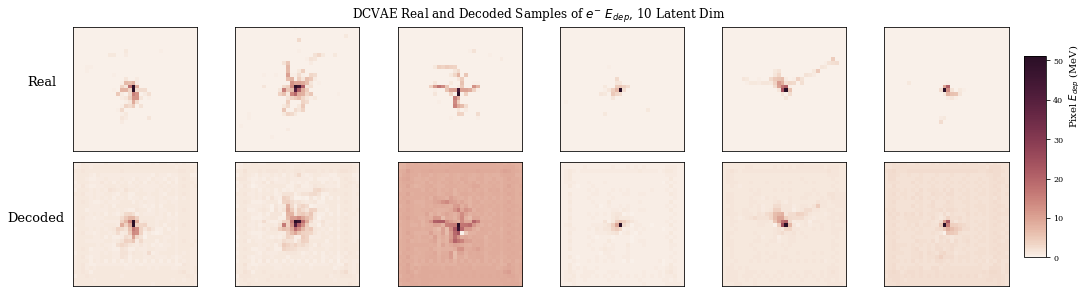

Train Epoch: 29 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 29 [1600/30000 (5%)]	Loss: -0.764746
Train Epoch: 29 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 29 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 29 [6400/30000 (21%)]	Loss: -0.764751
Train Epoch: 29 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 29 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 29 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 29 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 29 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 29 [16000/30000 (53%)]	Loss: -0.764780
Train Epoch: 29 [17600/30000 (59%)]	Loss: -0.764747
Train Epoch: 29 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 29 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 29 [22400/30000 (75%)]	Loss: -0.764779
Train Epoch: 29 [24000/30000 (80%)]	Loss: -0.764778
Train Epoch: 29 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 29 [27200/30000 (91%)]	Loss: -0.764747
Train Epoch: 29 [28800/30000 (96%)]	Loss: -0.764753
(32, 32, 32)
(45.72414, 

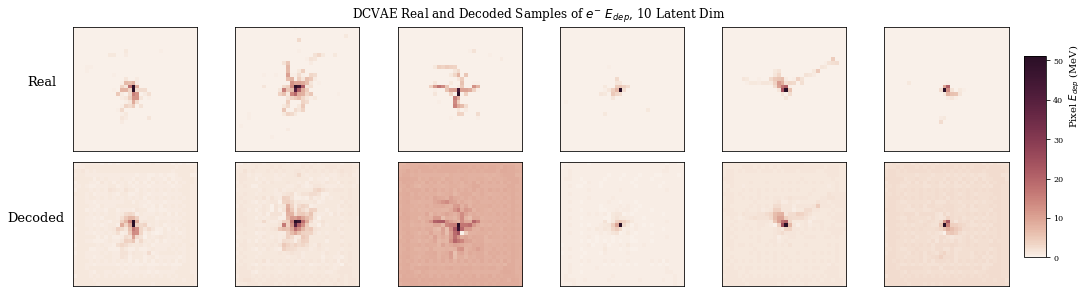

Train Epoch: 30 [0/30000 (0%)]	Loss: -0.764744
Train Epoch: 30 [1600/30000 (5%)]	Loss: -0.764746
Train Epoch: 30 [3200/30000 (11%)]	Loss: -0.764771
Train Epoch: 30 [4800/30000 (16%)]	Loss: -0.764783
Train Epoch: 30 [6400/30000 (21%)]	Loss: -0.764751
Train Epoch: 30 [8000/30000 (27%)]	Loss: -0.764720
Train Epoch: 30 [9600/30000 (32%)]	Loss: -0.764734
Train Epoch: 30 [11200/30000 (37%)]	Loss: -0.764738
Train Epoch: 30 [12800/30000 (43%)]	Loss: -0.764730
Train Epoch: 30 [14400/30000 (48%)]	Loss: -0.764722
Train Epoch: 30 [16000/30000 (53%)]	Loss: -0.764780
Train Epoch: 30 [17600/30000 (59%)]	Loss: -0.764747
Train Epoch: 30 [19200/30000 (64%)]	Loss: -0.764769
Train Epoch: 30 [20800/30000 (69%)]	Loss: -0.764746
Train Epoch: 30 [22400/30000 (75%)]	Loss: -0.764779
Train Epoch: 30 [24000/30000 (80%)]	Loss: -0.764778
Train Epoch: 30 [25600/30000 (85%)]	Loss: -0.764733
Train Epoch: 30 [27200/30000 (91%)]	Loss: -0.764747
Train Epoch: 30 [28800/30000 (96%)]	Loss: -0.764753


In [32]:

mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/ConVAE/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

with open(mydir + 'NetworkInfo.txt', 'w') as f:
    print >> f, 'model:', model
    

for epoch in range(1,  num_epochs + 1):
    plot_reconstructions(model, save_dir=mydir, n=6, conv=True, epoch = epoch, simple=False)
    train(epoch)

(32, 32, 32)
(45.774147, 46.276417)
(45.70729, 46.273777)
(44.876877, 46.275337)
(45.79074, 46.2707)
(45.3177, 46.267853)


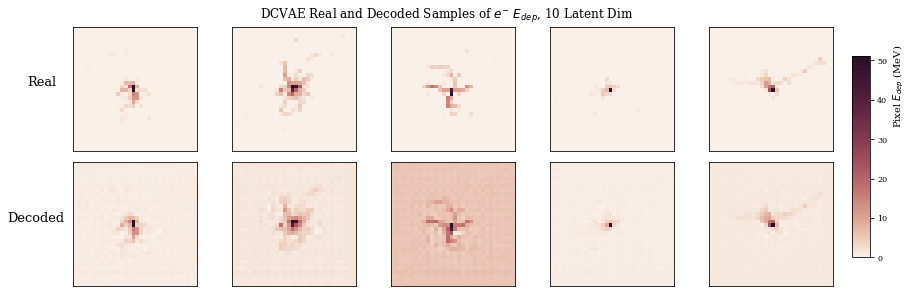

In [27]:
plot_reconstructions(model, save_dir=None, conv=True, simple=False, n=5)

In [ ]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/ConVAE/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [ ]:
data= next(iter(test_loader))
#print(data[0].shape)
#print norm_scale

#data = Variable(data, volatile=True)
true_imgs = data[0]
encoded_imgs = model.encoder(data[0].to(device))
#if simple:
#    encoded_imgs = F.relu(encoded_imgs)
decoded_imgs = model.decoder(encoded_imgs)
#print(decoded_imgs)
true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)

In [ ]:
plt.figure(figsize= (10,10))
im = plt.imshow(true_imgs[2] - decoded_imgs[2])
plt.colorbar(im)

In [ ]:
combined_fake_image = 0
for i in range(len(decoded_imgs)):
    combined_fake_image += decoded_imgs[i]
combined_fake_image = combined_fake_image / len(true_imgs)

combined_real_image = 0
for i in range(len(true_imgs)):
    combined_real_image += true_imgs[i]
combined_real_image = combined_real_image / len(true_imgs) - 28

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(combined_real_image, cmap ='PuOr')
plt.colorbar(im)

(32, 32, 32)


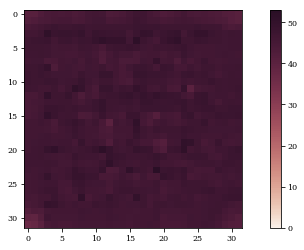

In [363]:
# nz = 10
# data = torch.FloatTensor(np.random.uniform(low=0,high=20,size= (batchSize,nz,6,6))).to(device)
# #data = torch.randn(batchSize,nz,6,6).to(device)
# #print(data)
                 
# decoded_imgs = unnormalize(model.decoder(data).cpu().data.numpy().reshape([-1,32,32]),scale=scale,norm_scale=norm_scale)
# #print(decoded_imgs)
# #true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
# #decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
# print(decoded_imgs.shape)

# n=4
# rowsize = n * 2.5
# columnsize = 4

# fig, ax = plt.subplots(figsize=(rowsize, columnsize))
# cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
# im = ax.imshow(decoded_imgs[0], cmap=cmap, vmin=0)
# plt.colorbar(im)
